# Modeling and Predictions

### Cleaning
1. Weather data prep

### Feature Engineering
2. Engineering weather features
    - Rolling averages
    - Combine same-day trap results
3. Location weighting
4. Clustering
5. Combine weather and train datasets
6. Interaction effects

### Munging
7. Undersampling
8. Feature selection
    - Get dummies 
    - Scaling
    - Concat
    - Omit columns not in test dataset
    
### Modeling
9. Train test split
10. Modeling
11. Predict

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

# importing models:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline

all_start_time = time.time() # this is to keep a tab on how long it takes this notebook to run


In [2]:
train = pd.read_csv('assets/train.csv')
test = pd.read_csv('assets/test.csv')
dirty_weather = pd.read_csv('assets/weather.csv')

## Weather Data Prep:

In [3]:
# dropped features from weather:
#     hot, cool -deemed unnecessary
#     water1 this is entirely missing values
#     depth contains only zeros and missing values(for station 2), no information
#     Snowfall because all but 13 values were either 0 or missing
#     Codesum because that information is contained in precipitation (mostly)

to_drop = ['Heat', 'Cool', 'Water1', 'Depth', 'SnowFall', 'CodeSum']
weather = dirty_weather.drop(axis = 1, columns = to_drop)

# precip "Trace" ('T') amounts are defined as less than (0.005 inch) according to chicagotribune
weather['PrecipTotal'].replace(to_replace = 'T', value = 0.005, inplace=True, regex = True)

In [4]:
weather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Sunrise,Sunset,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0448,1849,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,-,-,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,0447,1850,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,-,-,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,0446,1851,0.00,29.39,30.12,11.7,7,11.9


In [5]:
for i in range(len(weather)): #for each row in weather
    if i != 0:
        if weather.loc[i, 'Date'] == weather.loc[i-1, 'Date']: # if the date is the same as the previou value
            for col in weather.columns:
                if col in ['Station', 'Date']: #skip these columns
                    continue
                elif col in ['Depart', 'Sunrise', 'Sunset']:
                    weather.loc[i, col] = weather.loc[i-1, col] # keep the 'Depart' value from station 1
                elif weather.loc[i, col] == 'M':
                    weather.loc[i, col] = weather.loc[i-1, col] # if the value is missing, take it from station 1
                elif weather.loc[i-1, col] == 'M':
                    weather.loc[i-1, col] = weather.loc[i, col] # make sure no 'M's are called from station 1
                else:
                    weather.loc[i, col] =  (float(weather.loc[i, col]) + float(weather.loc[i-1, col]))/2 # average the data from the two stations
            weather.drop(index=(i-1), inplace=True) # drop previous row
weather.drop(axis=1, columns = 'Station', inplace=True)

In [6]:
# convert 'Date' to datetime object
weather['Date'] = weather['Date'].apply(pd.to_datetime, errors='coerce')

# turn object columns into numeric datatypes
obj_cols = ['WetBulb', 'SeaLevel', 'Tavg', 'AvgSpeed', 'PrecipTotal', 'Depart', 'StnPressure', 'Sunset', 'Sunrise'] 
weather[obj_cols] = weather[obj_cols].apply(pd.to_numeric, errors='coerce', axis=0)

In [7]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1472 entries, 1 to 2943
Data columns (total 15 columns):
Date           1472 non-null datetime64[ns]
Tmax           1472 non-null float64
Tmin           1472 non-null float64
Tavg           1472 non-null float64
Depart         1472 non-null int64
DewPoint       1472 non-null float64
WetBulb        1472 non-null float64
Sunrise        1472 non-null int64
Sunset         1472 non-null int64
PrecipTotal    1472 non-null float64
StnPressure    1471 non-null float64
SeaLevel       1472 non-null float64
ResultSpeed    1472 non-null float64
ResultDir      1472 non-null float64
AvgSpeed       1472 non-null float64
dtypes: datetime64[ns](1), float64(11), int64(3)
memory usage: 184.0 KB


# Engineering Weather Features:

### Calculate Day Length:

In [8]:
weather['daylength'] = weather['Sunset'] - weather['Sunrise']
weather.head()

,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Sunrise,Sunset,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,daylength
1,2007-05-01,83.5,51.0,67.5,14,51.0,56.5,448,1849,0.0000,29.140,29.820,2.20,26.0,9.40,1401
3,2007-05-02,59.5,42.5,51.5,-3,42.0,47.0,447,1850,0.0000,29.410,30.085,13.15,3.0,13.40,1403
5,2007-05-03,66.5,47.0,57.0,2,40.0,49.0,446,1851,0.0000,29.425,30.120,12.30,6.5,12.55,1405
7,2007-05-04,72.0,50.0,58.0,4,41.5,50.0,444,1852,0.0025,29.335,30.045,10.25,7.5,10.60,1408
9,2007-05-05,66.0,53.5,60.0,5,38.5,49.5,443,1853,0.0050,29.430,30.095,11.45,7.0,11.75,1410


### Rolling Averages:

In [9]:
# make a running total of precipitation over the past X days_back
days_back_precip = 15

# create the running_PrecipTotal column
weather['running_PrecipTotal'] = weather['PrecipTotal'].rolling(window = days_back_precip).mean()
weather['running_PrecipTotal'].fillna(value=0, inplace=True)

# create the running_PrecipTotal column
days_back_Tavg = 3

weather['running_Tavg'] = weather['Tavg'].rolling(window = days_back_Tavg).mean()
weather['running_Tavg'].fillna(value=60, inplace=True)

# AvgSpeed
days_back_AvgSpeed = 3

weather['running_AvgSpeed'] = weather['AvgSpeed'].rolling(window = days_back_AvgSpeed).mean()
weather['running_AvgSpeed'].fillna(value=10, inplace=True)

### Combine same-day trap rows into a single day:

In [10]:
# create a new column for each species to prepare it for the loops below

species = list(train.Species.unique())
for df in [train]: #, test]:
    for species_type in species:
        df[species_type] = 0

In [11]:
#################################################################################
# Combine the same-day trap rows
#     if this is sorted by date and trap then it will iterate in the right order
#################################################################################

for i in range(len(train)):
    if i != 0:
        if (train.loc[i,'Date'] == train.loc[i-1,'Date']) & (train.loc[i,'Trap'] == train.loc[i-1,'Trap']): # conditions for when the previous row has the same date and time value
            col = train.loc[i,'Species']
            train.loc[i, col] = train.loc[i-1, col] + train.loc[i, 'NumMosquitos'] # put the number of mosquitos in the right species column
            for _ in species:
                if _ != col:
                    train.loc[i, _] = train.loc[i, _] + train.loc[i-1, _] # keep track of the other species counts
            if train.loc[i-1, 'WnvPresent'] == 1:
                train.loc[i, 'WnvPresent'] = 1    # Keep track of if Wnv is present
            train.drop(index=(i-1), inplace=True)   # drop previous duplicate row now that its info is copied
        else:
            col = train.loc[i,'Species']
            train.loc[i, col] = train.loc[i, col] + train.loc[i, 'NumMosquitos'] # keep track of species counts
    else: #this should only apply to row_index = 0, it avoids an error from looking back past the first observation
        col = train.loc[i,'Species']
        train.loc[i, col] += train.loc[i, 'NumMosquitos']
train.reset_index(inplace= True)

In [12]:
# calculate total mosquitos in each trap
train['total_mos'] = train[species].sum(axis=1) 

# drop species and nummos
train.drop(columns = ['Species', 'NumMosquitos'], inplace = True)

In [13]:
# Assigning to a week of the year

train['Date'] = pd.to_datetime(train['Date'])
train['week_no'] = [x.isocalendar()[1] for x in train['Date']]
train['peak_season_diff'] = (train['week_no'] - 31) # number of weeks from peak wnv season (week 31)

test['Date'] = pd.to_datetime(test['Date'])
test['week_no'] = [x.isocalendar()[1] for x in test['Date']]
test['peak_season_diff'] = (test['week_no'] - 31) # number of weeks from peak wnv season (week 31)

In [14]:
# weight weeks according to mosq pop
grand_total_mosq = train['total_mos'].sum()

for x in train['week_no'].unique():
    week_no_pop = train.loc[(train['week_no'] == x), 'total_mos'].sum()
    train.loc[train['week_no'] == x, 'weighted_week_no'] = week_no_pop/grand_total_mosq *100
    test.loc[test['week_no'] == x, 'weighted_week_no'] = week_no_pop/grand_total_mosq *100

# Location weighting

In [15]:
# Make "trap weight" feature. If traps have high frequency of WNV, weight them higher.

In [16]:
# Out of number of reports for trap, what % is WNV present?
for x in train['Trap'].unique():
    num_reports = len(train.loc[train['Trap'] == x])
    num_wnv = len(train.loc[(train['Trap'] == x) & (train['WnvPresent'] == 1)])
    train.loc[train['Trap'] == x, 'trap_weight'] = num_wnv/num_reports
    test.loc[test['Trap'] == x, 'trap_weight'] = num_wnv/num_reports

In [17]:
# Percentage of nulls in test set.
test.isnull().sum()['trap_weight'] / len(test)

0.08517279629900337

In [18]:
# Fills test NaNs with train avg.
test.fillna(train['trap_weight'].mean(), inplace=True)

<hr>
# Clustering

In [19]:
X = train[['Latitude', 'Longitude', 'trap_weight']]

n_clusters = 10

kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(X)
    
X['kmeans_label'] = kmeans.labels_
train['kmeans_label'] = kmeans.labels_


dbs = DBSCAN(eps=0.15, min_samples=7) 
dbs.fit(X)
    
X['dbs_label'] = dbs.labels_
train['dbs_label'] = dbs.labels_

agg = AgglomerativeClustering(n_clusters=n_clusters)
agg.fit(X)
    
X['agg_label'] = agg.labels_
train['agg_label'] = agg.labels_

/Users/zachgreen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/zachgreen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/zachgreen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

In [20]:
for x in train['Trap'].unique():
    test.loc[test['Trap'] == x, 'kmeans_label'] = train.loc[train['Trap'] == x, 'kmeans_label'].mean()
    test.loc[test['Trap'] == x, 'dbs_label'] = train.loc[train['Trap'] == x, 'dbs_label'].mean()
    test.loc[test['Trap'] == x, 'agg_label'] = train.loc[train['Trap'] == x, 'agg_label'].mean()

In [21]:
test.isnull().sum()

Id                           0
Date                         0
Address                      0
Species                      0
Block                        0
Street                       0
Trap                         0
AddressNumberAndStreet       0
Latitude                     0
Longitude                    0
AddressAccuracy              0
week_no                      0
peak_season_diff             0
weighted_week_no             0
trap_weight                  0
kmeans_label              9905
dbs_label                 9905
agg_label                 9905
dtype: int64

In [22]:
test.fillna(0, inplace=True)

# Combine Weather with Train and Test Sets

In [23]:
# make a list of the weather features and remove 'Date'
weather_feat = list(weather.columns)
weather_feat.remove('Date')

In [24]:
for df in [train, test]:
    for thing in weather_feat:
        df[thing] = 0

In [25]:
for _ in train['Date'].unique():  
    for x in weather.columns[1:]:        
        train.loc[train['Date'] == _, x] = weather.loc[weather['Date'] == _, x].values[0]
        
for _ in test['Date'].unique():  
    for x in weather.columns[1:]:        
        test.loc[test['Date'] == _, x] = weather.loc[weather['Date'] == _, x].values[0]

# Interaction Effects:

In [26]:
# time from peak season vs precipitation running average
train['peak_season_diff_vs_running_Precip'] = train['peak_season_diff'] * train['running_PrecipTotal']
test['peak_season_diff_vs_running_Precip'] = test['peak_season_diff'] * test['running_PrecipTotal']

# time from peak season vs temp running average
train['peak_season_diff_vs_running_Tavg'] = train['peak_season_diff'] * train['running_Tavg']
test['peak_season_diff_vs_running_Tavg'] = test['peak_season_diff'] * test['running_Tavg']

# time from peak season vs wind running average
train['peak_season_diff_vs_running_AvgSpeed'] = train['peak_season_diff'] * train['running_AvgSpeed']
test['peak_season_diff_vs_running_AvgSpeed'] = test['peak_season_diff'] * test['running_AvgSpeed']

<hr>

# Undersampling

In [27]:
### Undersampling (from http://blog.madhukaraphatak.com/class-imbalance-part-2/)

# Number of wnv cases
wnv = len(train[train['WnvPresent'] == 1])

# non-wnv indexes
nonwnv_index = train[train['WnvPresent'] == 0].index

# random index
rando_index = np.random.choice(nonwnv_index, wnv*2, replace=False) # Change the coef of wmv to change class balance

# wnv index
wnv_index = train[train['WnvPresent'] == 1].index

# undersample
undersample = np.concatenate([rando_index, wnv_index])
undersample = train.loc[undersample]

In [28]:
# Class balance
undersample['WnvPresent'].value_counts()

0    770
1    385
Name: WnvPresent, dtype: int64

<hr>

# Feature selection

In [29]:
# Select features

# categorical vars
cat = ['agg_label']

feat = ['Tavg', 'PrecipTotal', 'trap_weight', 'WetBulb', 'daylength',
        'AvgSpeed',  'StnPressure', 'peak_season_diff',
        'running_PrecipTotal', 'running_Tavg', 'running_AvgSpeed', #running weather averages 
        'peak_season_diff_vs_running_Precip', 'peak_season_diff_vs_running_Tavg', 'peak_season_diff_vs_running_AvgSpeed', # interaction effects
       ]

<hr>

### Makes get_dummies for addresses, scales continuous, and concatenates.

In [30]:
### Get dummies for addresses, scale continuous features, concatenate.

### Train ###

address_dummies = pd.get_dummies(undersample['AddressNumberAndStreet'])

# Scaling
ss = StandardScaler()
scaled = ss.fit_transform(undersample[feat])
scaled = pd.DataFrame(scaled, index=undersample.index, columns=undersample[feat].columns)

# Concat
train_scaled = pd.concat([scaled, address_dummies, undersample[cat]], axis=1)


### Test ###

address_dummies = pd.get_dummies(test['AddressNumberAndStreet'])

# Scaling
ss = StandardScaler()
test_scaled = ss.fit_transform(test[feat])
test_scaled = pd.DataFrame(test_scaled, index=test.index, columns=test[feat].columns)

# Concat
test_scaled = pd.concat([test_scaled, address_dummies, test[cat]], axis=1)

### Checks columns for features in test NOT in train

In [31]:
# for pf

# Check for columns in test not in train.
no_addresses = [x for x in test_scaled.columns if x not in train_scaled.columns]

### Print all addresses in test not in train set. ###
print(no_addresses)

# Dataset with unincluded addresses omitted.
test_no_addresses = test_scaled.drop(no_addresses, axis=1)

['1000  S OGLESBY AVE, Chicago, IL', '1100  S LOOMIS ST, Chicago, IL', '1200  S BALTIMORE AVE, Chicago, IL', '1200  W 120TH ST, Chicago, IL', '1400  W 112TH ST, Chicago, IL', '2100  S HAMLIN AVE, Chicago, IL', '2600  E 136TH ST, Chicago, IL', '2900  N KENNETH AVE, Chicago, IL', '2900  W 85TH ST, Chicago, IL', '3400  N LONG AVE, Chicago, IL', '3700  N KILBOURN AVE, Chicago, IL', '4000  N KEDVALE AVE, Chicago, IL', '4600  N MELVINA AVE, Chicago, IL', '5100  W 63RD PL, Chicago, IL', '6500  W DAKIN ST, Chicago, IL', '8000  S KEDZIE AVE, Chicago, IL']


# Train Test Split

In [32]:
# # tts for pf
X_train, X_test, y_train, y_test = train_test_split(train_scaled, undersample['WnvPresent'], stratify=undersample['WnvPresent'])

# Modeling Function:
This function fits the model passed in and gridsearches over the specified parameters <br>

### It prints out:
The model results. <br> 
Best performing parameters for examination.<br>
ROC Curve.

### Returns: 
The updated overall results dataframe. <br>
The best parameters dataframe. <br>
The best fitted model. <br>

In [33]:
# instantiating dataframes that will be used to store results and parameters of models tested
index_labels = ['Test score','Train score', 'Sensitivity', 'Specificity', 'Precision']
all_results = pd.DataFrame(index=index_labels)
all_params = pd.DataFrame(columns = ['Parameters'])

# set dataframe options to display long strings rather than truncating them
#     so that you can see all the parameters used
pd.set_option('display.max_colwidth', 10000)

In [34]:
def fit_model(model, model_name, params, all_results, all_params):
    start_time = time.time() # this is to keep a tab on how long it takes this function to run
    
##################################################################################################
# This function fits the model passed in and gridsearches over the specified parameters
#     it then displays the results and best parameters 
#         and adds them to two dataframes that store results and parameters of all previous models
# 
# Returns: the overall results dataframe, the best parameters dataframe, and the best fitted model
##################################################################################################

    # fit
    model = GridSearchCV(model, params, n_jobs=-1, cv = 3)
    model.fit(X_train, y_train)
    
    # pick out the best model
    best_model = model.best_estimator_
    
    # make predictions
    pred = best_model.predict(X_test)
    
    # make the confusion matrix
    pred = best_model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
    
    # Calculate Scores and put them in results dataframe
    index_labels = ['Test score', 'Train score', 'Sensitivity', 'Specificity', 'Precision']
    result = pd.DataFrame(index = index_labels, columns=[model_name])
    result.loc['Test score'][model_name] = round(best_model.score(X_test, y_test), 3)
    result.loc['Train score'][model_name] = round(model.best_score_, 3)
    result.loc['Sensitivity'][model_name] = round(tp/(tp+fn), 3)
    result.loc['Specificity'][model_name] = round(tn/(tn+fp), 3)
    result.loc['Precision'][model_name] = round(tp/(tp+fp), 3)
    display(result)
    
    # add results and params to all_results and all_params
    all_results = pd.concat([all_results, result], axis=1)
    result_series = pd.Series({'Parameters' : model.best_params_}, name=model_name)
    all_params = all_params.append(result_series)
    display(all_params.loc[[model_name]])
    
    # Create the confusion matrix dataframe
    total = (tp + tn + fp + fn)
    confusion = pd.DataFrame(index= ['Pred. Positive','Pred. Negative', 'Total'])
    confusion['Act. Positive'] = str(round(tp/total*100, 1))+'%', str(round(fn/total*100, 1))+'%', (tp + fn)
    confusion['Act. Negative'] = str(round(fp/total*100, 1))+'%', str(round(tn/total*100, 1))+'%', (fp + tn)
    confusion['Total'] = (tp + fp), (fn + tn), total
    display(confusion)
    
# ROC-AUC curve
    # make predicted probabilities to be returned for use in the ROC Curve
    y_hat_proba = best_model.predict_proba(X_test)

    # Generate False positive rate and True positive rate
    fpr, tpr, _ = roc_curve(y_test, y_hat_proba[:,1])
    roc_auc = auc(fpr, tpr)

    # Plot 
    plt.figure(figsize=(6, 4))
    line_width = 4
    plt.title('ROC Curve', fontsize=25, position = (0.2,1))
    plt.ylabel('TPR')
    plt.xlabel('FPR')
    plt.grid(True)
    plt.plot(fpr, tpr, lw = line_width)
    plt.plot([0, 1], [0,1], lw = line_width, linestyle = '--')
    plt.show()
    
    print('ROC AUC Score: ', roc_auc)
    
    # print the runtime
    end_time = time.time()
    print('Runtime: ', round((end_time - start_time)/60, 3), ' minutes')
    return all_results, all_params, best_model

# Fit Models!

### Logisitic Regression:

,Log Reg
Test score,0.713
Train score,0.792
Sensitivity,0.479
Specificity,0.829
Precision,0.582


,Parameters
Log Reg,"{'C': 0.33, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.05, 'warm_start': False}"


,Act. Positive,Act. Negative,Total
Pred. Positive,15.9%,11.4%,79
Pred. Negative,17.3%,55.4%,210
Total,96,193,289


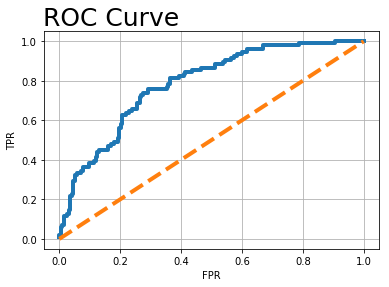

ROC AUC Score:  0.7837327288428325
Runtime:  0.029  minutes


In [35]:
params = {
    'penalty': ['l1', 'l2'],
    'C': [.1, 0.25, .33, 0.5, .75, 1, 2, 5, 10, 15, 20],
    'solver': ['liblinear'],
    'warm_start' : [True, False],
    'tol': [0.05, 0.01, 0.005]}

all_results, all_params, lr_best_model = fit_model(LogisticRegression(), 'Log Reg', #(function call, 'Name to Print'
                                                   params, all_results, all_params)


### Naive Bayes:

,Berni NB
Test score,0.692
Train score,0.744
Sensitivity,0.552
Specificity,0.762
Precision,0.535


,Parameters
Berni NB,"{'alpha': 10, 'fit_prior': False}"


,Act. Positive,Act. Negative,Total
Pred. Positive,18.3%,15.9%,99
Pred. Negative,14.9%,50.9%,190
Total,96,193,289


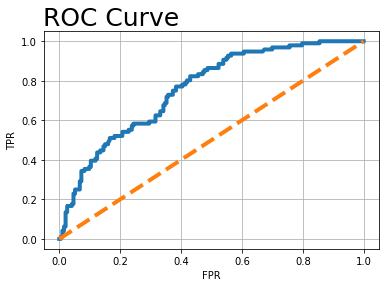

ROC AUC Score:  0.7576101036269429
Runtime:  0.011  minutes


In [36]:
# This uses BernoulliNB because we are trying to predict a binomial variable

params = {
    'fit_prior': [True, False],
    'alpha': [0.5, 1, 2, 3, 5, 10, 15, 20]
}
all_results, all_params, nb_best_model = fit_model(BernoulliNB(), 'Berni NB', params, all_results, all_params)

### SVM:

,SVM
Test score,0.754
Train score,0.799
Sensitivity,0.552
Specificity,0.855
Precision,0.654


,Parameters
SVM,"{'C': 10, 'decision_function_shape': 'ovr', 'kernel': 'rbf', 'shrinking': True}"


,Act. Positive,Act. Negative,Total
Pred. Positive,18.3%,9.7%,81
Pred. Negative,14.9%,57.1%,208
Total,96,193,289


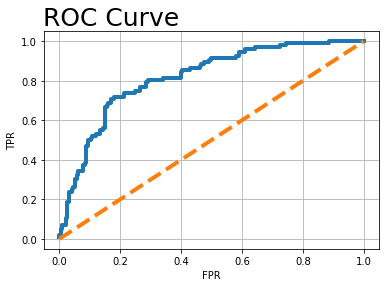

ROC AUC Score:  0.8168177892918825
Runtime:  0.558  minutes


In [37]:
params = {
    'kernel': ['rbf', 'linear'],
    'C': [1, 1.5, 2, 5, 7, 10, 15],
    'shrinking': [True, False],
    'decision_function_shape' : ['ovr', 'ovo'],
    }

all_results, all_params, svm_best_model = fit_model(svm.SVC(probability=True), 'SVM', params, all_results, all_params)

### KNN:

,KNN
Test score,0.772
Train score,0.797
Sensitivity,0.573
Specificity,0.87
Precision,0.688


,Parameters
KNN,"{'metric': 'minkowski', 'n_neighbors': 40, 'p': 1, 'weights': 'distance'}"


,Act. Positive,Act. Negative,Total
Pred. Positive,19.0%,8.7%,80
Pred. Negative,14.2%,58.1%,209
Total,96,193,289


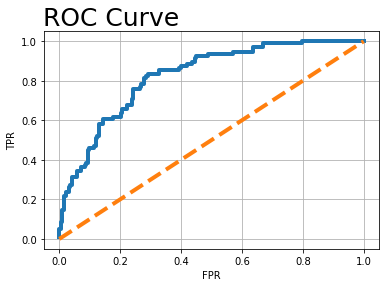

ROC AUC Score:  0.8244818652849741
Runtime:  0.155  minutes


In [38]:
params = {
    'n_neighbors': [3, 4, 5, 10, 15, 20, 30, 40, 50],
    'weights': ['distance'],
    'metric': ['minkowski'],
    'p': [1, 2, 3] # p = 1 and 2 correspondes to Manhattan and Euclidean distance metrics repsectively
}
all_results, all_params, knn_best_model = fit_model(KNeighborsClassifier(), 'KNN', params, all_results, all_params)

### Random Forest:

In [ ]:
max_feat_default = np.sqrt(len(X_train.columns))
max_feat_to_check = range(
                        int(max_feat_default - 0 * max_feat_default), # 0% lowerbound of default setting: sqrt(features)
                        int(max_feat_default + 4 * max_feat_default), # 200% upperbound of default setting: sqrt(features)
                        int(2 * max_feat_default)) # Step size: 50% of default: sqrt(features)
# max_feat_to_check.append(None)

params = {
    'n_estimators': [60, 75, 90],
    'min_samples_split': [3, 4],
    'min_samples_leaf': [6, 7],
    'bootstrap': [False],
    'max_depth':[7, 10],
    'max_leaf_nodes': [None],
    'max_features': max_feat_to_check
}
all_results, all_params, rf_best_model = fit_model(RandomForestClassifier(), 'Random Forest', params, all_results, all_params)

print('Max features default: ', max_feat_default)

# Top features
feat_importance = pd.DataFrame(rf_best_model.feature_importances_, index=X_train.columns).sort_values(by=0, ascending=False)
feat_importance.head(10).plot(kind='barh')

## ExtraTrees:

In [ ]:
# Extra Trees
et_params = {
    'n_estimators': [60, 75, 90],
    'min_samples_split': [5, 6],
    'min_samples_leaf': [3, 4, 5],
    'max_depth':[5, 10, 20],
    'max_leaf_nodes': [10, 20, 30],
    'bootstrap': [False],
    'max_features': [None]
}

all_results, all_params, et_best_model = fit_model(ExtraTreesClassifier(), 'Extra Trees', et_params, all_results, all_params)


# plot important features
feat_importance = pd.DataFrame(et_best_model.feature_importances_, X_train.columns, columns=['importance'])
feat_importance.sort_values('importance', ascending=False).head(10).plot(kind='barh')

# Adaboost:

In [ ]:
# AdaBoost
ada_params = {
    'n_estimators': [10, 25, 50, 100],
    'learning_rate': [.25, .75, 1.0, 1.25, 2, 5],
}

all_results, all_params, ada_best_model = fit_model(AdaBoostClassifier(), 'AdaBoost', ada_params, all_results, all_params)


# plot important features
feat_importance = pd.DataFrame(ada_best_model.feature_importances_, X_train.columns, columns=['importance'])
feat_importance.sort_values('importance', ascending=False).head(10).plot(kind='barh')

In [ ]:
# checking with daylength added and mosq peak season changes to wmv peak (week 31)
#     .79, .81, .77, .80, .80, .78, .78

<hr>
# Results from all Models Tested:

In [ ]:
all_results['Overall Average Score'] = round(all_results.mean(axis=1), 3)
display(all_results)
display(all_params)

<hr>
# Make Predictions and Save to .CSV

In [ ]:
# Make predictions on the test set with one of the best models
pred = rf_best_model.predict(test_no_addresses)

In [ ]:
# Check predictions to see if it worked.
pd.DataFrame(pred)[0].value_counts()

In [ ]:
# Make .csv
submission = pd.concat([test['Id'], pd.Series(pred)], axis=1).set_index('Id')
submission = submission.rename({0: 'WnvPresent'}, axis='columns')
submission.to_csv('submission/submission_' + str(int(time.time())) + '.csv')

In [ ]:
# print the runtime
all_end_time = time.time()
print('Overall Runtime: ', round((all_end_time - all_start_time)/60, 3), ' minutes')

Kaggle submission site:
https://www.kaggle.com/c/predict-west-nile-virus/leaderboard